In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
import random
import tensorflow.keras.utils as utils
import pydot
from tensorflow.keras import regularizers

In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_gpu_available()
!python --version

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4247151177892410152
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 8713155643105934058
physical_device_desc: "device: XLA_CPU device"
]
2.3.1
Num GPUs Available:  0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
/bin/bash: python: command not found


In [3]:
dataset_dir = "./Datasets/energydata_complete.csv"

In [4]:
df = pd.read_csv(dataset_dir, index_col=0)
df = df.fillna(df.mean())
df['telco'] = np.random.randint(0, 2, df.shape[0])
df['bank'] = np.random.randint(0, 2, df.shape[0])
df.head(10)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,telco,bank
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.890000,47.596667,19.20,44.790000,19.79,44.730000,19.000000,45.566667,...,6.600000,733.500000,92.000000,7.000000,63.000000,5.300000,13.275433,13.275433,0,1
2016-01-11 17:10:00,60,30,19.890000,46.693333,19.20,44.722500,19.79,44.790000,19.000000,45.992500,...,6.483333,733.600000,92.000000,6.666667,59.166667,5.200000,18.606195,18.606195,0,0
2016-01-11 17:20:00,50,30,19.890000,46.300000,19.20,44.626667,19.79,44.933333,18.926667,45.890000,...,6.366667,733.700000,92.000000,6.333333,55.333333,5.100000,28.642668,28.642668,0,0
2016-01-11 17:30:00,50,40,19.890000,46.066667,19.20,44.590000,19.79,45.000000,18.890000,45.723333,...,6.250000,733.800000,92.000000,6.000000,51.500000,5.000000,45.410389,45.410389,1,1
2016-01-11 17:40:00,60,40,19.890000,46.333333,19.20,44.530000,19.79,45.000000,18.890000,45.530000,...,6.133333,733.900000,92.000000,5.666667,47.666667,4.900000,10.084097,10.084097,1,0
2016-01-11 17:50:00,50,40,19.890000,46.026667,19.20,44.500000,19.79,44.933333,18.890000,45.730000,...,6.016667,734.000000,92.000000,5.333333,43.833333,4.800000,44.919484,44.919484,0,1
2016-01-11 18:00:00,60,50,19.890000,45.766667,19.20,44.500000,19.79,44.900000,18.890000,45.790000,...,5.900000,734.100000,92.000000,5.000000,40.000000,4.700000,47.233763,47.233763,0,0
2016-01-11 18:10:00,60,50,19.856667,45.560000,19.20,44.500000,19.73,44.900000,18.890000,45.863333,...,5.916667,734.166667,91.833333,5.166667,40.000000,4.683333,33.039890,33.039890,0,1
2016-01-11 18:20:00,60,40,19.790000,45.597500,19.20,44.433333,19.73,44.790000,18.890000,45.790000,...,5.933333,734.233333,91.666667,5.333333,40.000000,4.666667,31.455702,31.455702,0,1


array([[<AxesSubplot:title={'center':'Appliances'}>]], dtype=object)

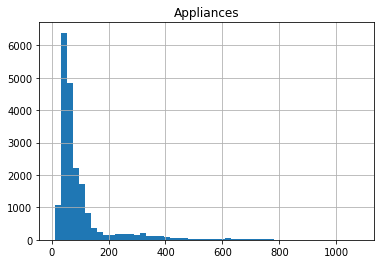

In [5]:
df.hist(column="Appliances", bins=50)

In [6]:
df.isnull().values.any()

False

In [7]:
df = df.sample(frac=1, random_state=41)

In [8]:
col_num = len(df.columns)
row_num = len(df.index)
print("Number of columns is: {} and number of rows is: {}".format(col_num, row_num))

Number of columns is: 30 and number of rows is: 19735


In [9]:
trainx = df.iloc[:int(0.8*row_num), 1:(col_num-4)]
trainy = df.iloc[:int(0.8*row_num), 0]

testx = df.iloc[int(0.8*row_num):, 1:(col_num-4)]
testy = df.iloc[int(0.8*row_num):, 0]

In [10]:
scaler = StandardScaler()
trainx_scaled = pd.DataFrame(scaler.fit_transform(trainx), columns = trainx.columns, index = trainx.index)
textx_scaled = pd.DataFrame(scaler.transform(testx), columns = testx.columns, index = testx.index)

In [11]:
group_A_train_x_op = trainx_scaled.iloc[:,[0,19,20,21,22,23,24]] 
group_B_train_x_op = trainx_scaled.iloc[:,[1,2,3,4,5,6,7,8,9,10]]
group_C_train_x_op = trainx_scaled.iloc[:,[11,12,13,14,15,16,17,18]]

group_A_test_x_op = textx_scaled.iloc[:,[0,19,20,21,22,23,24]]
group_B_test_x_op = textx_scaled.iloc[:,[1,2,3,4,5,6,7,8,9,10]]
group_C_test_x_op = textx_scaled.iloc[:,[11,12,13,14,15,16,17,18]]

In [12]:
size_inp_a = len(group_A_train_x_op.columns)
size_inp_b = len(group_B_train_x_op.columns)
size_inp_c = len(group_C_train_x_op.columns)

In [13]:
def get_MICS_model(inp_sizeA, inp_sizeB, inp_sizeC, use_encoders, drop_out, hidden_num = 4, hidden_size=32):
    inputs_A = keras.layers.Input(shape=(inp_sizeA), name="input_A")
    inputs_B = keras.layers.Input(shape=(inp_sizeB), name="input_B")
    inputs_C = keras.layers.Input(shape=(inp_sizeC), name="input_C")
    
    #If encoders are not to be used, inputs will be directly given to global model
    
    if use_encoders == True:
        encoder_A1 = get_encoder_model(inp_sizeA)
        encoder_A2 = get_encoder_model(inp_sizeA)        
        encoder_B1 = get_encoder_model(inp_sizeB)
        encoder_B2 = get_encoder_model(inp_sizeB)        
        encoder_C = get_encoder_model(inp_sizeC)
    
        global_inp_A = encoder_A(inputs_A)
        global_inp_B = encoder_B(inputs_B)
        global_inp_C = encoder_C(inputs_C)

        global_inp = keras.layers.concatenate([global_inp_A, global_inp_B, global_inp_C])
    else:
        global_inp = keras.layers.concatenate([inputs_A, inputs_B, inputs_C])
        
    h = keras.layers.Dense(hidden_size, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3))(global_inp)
    h = keras.layers.Dropout(drop_out)(h)
    for hidden in range(hidden_num):
        h = keras.layers.Dense(hidden_size, activation="relu", kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3))(h)
        h = keras.layers.Dropout(drop_out)(h) 

    outputs = keras.layers.Dense(1, activation="relu")(h)    
    return keras.Model(inputs=[inputs_A, inputs_B, inputs_C], outputs = outputs)

def get_encoder_model(inp_size):
    inputs = keras.layers.Input(shape=(inp_size))
    h1 = keras.layers.Dense(10, activation="relu")(inputs)
    outputs = keras.layers.Dense(inp_size, activation="relu")(h1)
    return keras.Model(inputs,outputs)

In [14]:
MICS_model = get_MICS_model(size_inp_a, size_inp_b, size_inp_c, use_encoders = True, drop_out = 0.25)
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50), 
        keras.callbacks.ReduceLROnPlateau("val_loss", factor = 0.8, patience=30,
                                         verbose = 2, mode = "auto", 
                                          min_lr = 1e-6)]
MICS_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=keras.losses.MeanSquaredError())
history = MICS_model.fit(x = [group_A_train_x_op.values, group_B_train_x_op.values, group_C_train_x_op.values], y = trainy.values,  
                         validation_data = ([group_A_test_x_op.values, group_B_test_x_op.values, group_C_test_x_op.values], testy.values),
                         epochs=300, batch_size = 300, callbacks=callback)
training_val_loss = history.history["val_loss"]
best_row_index = np.argmin(training_val_loss)
best_val_loss = training_val_loss[best_row_index]
best_val_loss

NameError: name 'encoder_A' is not defined

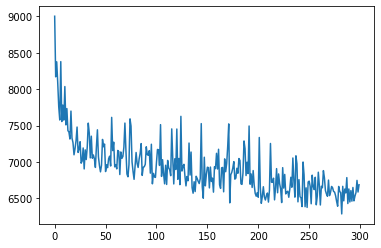

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history["val_loss"])